In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from src import dataset
from src import utils

In [20]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = '/data/ltorres'

In [6]:
train_paths = utils.get_gcd_paths(DATA_DIR, 'train')
test_paths = utils.get_gcd_paths(DATA_DIR, 'test')

In [82]:
train_dataset = dataset.GCD(train_paths, resize=224, use_augmentation=True)
test_dataset = dataset.GCD(test_paths, resize=224, use_augmentation=False)

In [83]:
train_loader = utils.build_data_loader(train_dataset, 32, shuffle=True)
test_loader = utils.build_data_loader(test_dataset, 32, shuffle=True)

---

In [84]:
from src.modules.graph_modules import GraphClassifier

In [13]:
device = 'cuda:3'
EPOCHS = 4
LR = 3e-4

In [132]:
model = GraphClassifier(
                 hidden_dim = 512, 
                 num_hidden = 2, 
                 num_classes = 7,
                 conv_type = 'gat',
                 conv_parameters = {'num_heads':4, 'residual': False, 'agg':'sum'},
                 adjacency_builder = 'cos_sim',
                 builder_parameter = 0.7,
                 use_both_heads = False,
                )

In [13]:
model = model.to(device)

In [133]:
crit_params = dict()
crit_params["hyperparameters"] = dict()
crit_params["model"] = dict()
crit_params["hyperparameters"]["criterion"] = 'cross_entropy'
crit_params["model"]["use_both_heads"] = False

In [134]:
optim_params = dict()
optim_params["hyperparameters"] = dict()
optim_params["hyperparameters"]["optimizer"] = 'adam'
optim_params["hyperparameters"]["learning_rate"] = 3e-4

In [135]:
model.graph_layers[0].conv.fc.weight.grad

In [136]:
batch = next(iter(train_loader))

In [137]:
log_l, log_r = model(batch['images'])

0 GraphAttentionLayer(
  (conv): GATConv(
    (fc): Linear(in_features=2048, out_features=2048, bias=False)
    (feat_drop): Dropout(p=False, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
)
0
1 GraphAttentionLayer(
  (conv): GATConv(
    (fc): Linear(in_features=512, out_features=2048, bias=False)
    (feat_drop): Dropout(p=False, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
)


In [138]:
criterions = utils.build_criterions(crit_params)

In [139]:
loss = criterions['main_head'](log_l, batch['targets'])

In [140]:
model.graph_layers[0].conv.fc.weight.grad

In [141]:
loss.backward()

In [142]:
model.graph_layers[0].conv.fc.weight.grad

tensor([[ 7.9534e-04, -2.6134e-03, -7.0916e-04,  ..., -2.2554e-03,
         -7.7730e-04, -2.6412e-05],
        [-3.0287e-03,  1.5719e-03,  5.2376e-03,  ...,  1.0080e-02,
          9.7355e-03, -5.3214e-03],
        [-6.8972e-03, -1.0852e-02, -1.0257e-02,  ..., -5.8926e-03,
         -1.1089e-02, -1.0731e-02],
        ...,
        [-9.8936e-04, -4.6764e-03, -2.6021e-03,  ..., -3.9911e-03,
         -2.2486e-03, -1.8864e-04],
        [ 2.9293e-04,  8.3049e-04,  5.8094e-04,  ...,  4.5014e-04,
          1.0384e-03,  8.6720e-04],
        [ 2.5062e-02,  3.5373e-02,  3.1972e-02,  ...,  1.8586e-02,
          2.8183e-02,  2.2588e-02]])

In [20]:
criterions = utils.build_criterions(crit_params)
optimizer = utils.build_optimizer(model, optim_params)

best_accuracy=0


for e in range(EPOCHS):
    train_loss, train_acc, train_targets, train_predictions = utils.train_model(
                                                                                    model, 
                                                                                    train_loader, 
                                                                                    criterions, 
                                                                                    optimizer, 
                                                                                    device, 
                                                                                    use_both_heads=False,
                                                                                    loss_lambda=1,
                                                                      )
    
    test_loss, test_acc, test_targets, test_predictions = utils.test_model(
                                                                                model, 
                                                                                test_loader, 
                                                                                criterions, 
                                                                                device, 
                                                                                use_both_heads=False,
                                                                                loss_lambda=1,
                                                                  )
    
    
    #train_acc = accuracy_score(train_targets, train_predictions)
    #test_acc = accuracy_score(test_targets, test_predictions)
    

    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format( 
        e+1,
        train_acc,
        train_loss,
        test_acc,
        test_loss
    ))

100%|██████████| 282/282 [00:41<00:00,  6.88it/s]


EPOCH 1: Train acc: 43.42% Train Loss: 0.8426 Test acc: 136.78% Test Loss: 0.6722


  2%|▏         | 6/313 [00:02<02:26,  2.09it/s]


KeyboardInterrupt: 

In [2]:
import pandas as pd

In [3]:
pd.read_csv("/data/ltorres/model_logs/wandb_33ei64m2_model.csv")

,type,epoch,loss,accuracy,experiment
0,train,1,0.578209,0.804400,1
1,test,1,0.920734,0.701222,1
2,train,2,0.406027,0.846400,1
3,test,2,0.941821,0.732333,1
4,train,1,0.579615,0.804300,2
5,test,1,1.206249,0.686889,2
6,train,2,0.406273,0.848600,2
7,test,2,0.933441,0.715111,2


In [171]:
t = torch.tensor([[1,1], [1,0]])

In [172]:
utils.get_matrix_density(t)

0.75

---

In [91]:
class CloudNet(nn.Module):
    def __init__(self, out_dims, dropout=0.5):
        super().__init__()
        self.dropout = dropout
        
        self.pool = nn.MaxPool2d(3, stride=2)
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4, bias=False)
        self.b1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=2, bias=False)
        self.b2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1, bias=False)
        self.b3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, padding=1, bias=False)
        self.b4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 6 * 6, 9216)
        self.fc2 = nn.Linear(9216, 4096)
        self.fc3 = nn.Linear(4096, out_dims)
        
    def forward(self, x):
        x = self.pool(F.relu(self.b1(self.conv1(x))))
        x = self.pool(F.relu(self.b2(self.conv2(x))))
        x = F.relu(self.b3(self.conv3(x)))
        x = self.pool(F.relu(self.b4(self.conv4(x))))
        x = x.flatten(1)
        x = F.dropout(F.relu(self.fc1(x)), self.dropout, training=self.training)
        x = F.dropout(F.relu(self.fc2(x)), self.dropout, training=self.training)
        x = self.fc3(x)
        return x

In [92]:
cloud_net = CloudNet( 7, 0.4)

In [93]:
cloud_net.conv1.in_channels

3

In [94]:
t = torch.rand(2,3,256,256)

In [95]:
5*5*224

5600

In [96]:
output = cloud_net(t)

In [97]:
F.softmax(output, 1)

tensor([[0.1620, 0.1685, 0.1750, 0.1002, 0.0874, 0.2013, 0.1057],
        [0.1895, 0.1525, 0.1611, 0.0888, 0.1244, 0.1332, 0.1504]],
       grad_fn=<SoftmaxBackward0>)

In [252]:
t = torch.tensor([1,2])

In [256]:
torch.stack([t,t], dim=0)

tensor([[1, 2],
        [1, 2]])

---

In [7]:
paths = train_paths[:4]

In [74]:
train_dset = dataset.GCDv2(paths, resize=224, use_augmentation=True)

Loading data to memory


100%|██████████| 4/4 [00:00<00:00, 81.56it/s]


In [75]:
train_dset.images[0].transpose(0,2).shape

torch.Size([224, 224, 3])

In [76]:
224*224*3

150528

In [77]:
(train_dset.images[4] == train_dset.images[5]).sum()

tensor(499)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


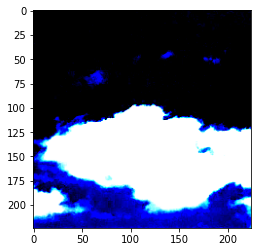

In [80]:
plt.imshow(train_dset.images[0].numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


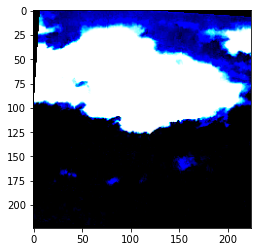

In [81]:
plt.imshow(train_dset.images[1].numpy().transpose(1,2,0))